# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import os
import torch
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


## Database

In [3]:
dataset_directory = "../datasets"
quickdraw_dataset_directory = dataset_directory + "/quickdraw_data"
print(os.path.abspath(quickdraw_dataset_directory))

G:\Python\doodle-recognition\datasets\quickdraw_data


In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.expandvars(
    r"%APPDATA%\gcloud\application_default_credentials.json"
)
os.environ["GOOGLE_CLOUD_PROJECT"] = "machine-learning-459222"

print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

C:\Users\frost\AppData\Roaming\gcloud\application_default_credentials.json


In [5]:
from datasets import download_quickdraw_simplified_dataset, parse_quickdraw_simplified_dataset, blob_names_for_quickdraw_simplified_dataset
blob_names = blob_names_for_quickdraw_simplified_dataset()

C:\Users\frost\miniconda3\envs\Python3.10.0\lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
download_quickdraw_simplified_dataset(destination_directory=quickdraw_dataset_directory, blob_names=blob_names)

skipping full/simplified/The Eiffel Tower.ndjson (already exists)
skipping full/simplified/The Great Wall of China.ndjson (already exists)
skipping full/simplified/The Mona Lisa.ndjson (already exists)
skipping full/simplified/aircraft carrier.ndjson (already exists)
skipping full/simplified/airplane.ndjson (already exists)
skipping full/simplified/alarm clock.ndjson (already exists)
skipping full/simplified/ambulance.ndjson (already exists)
skipping full/simplified/angel.ndjson (already exists)
skipping full/simplified/animal migration.ndjson (already exists)
skipping full/simplified/ant.ndjson (already exists)
skipping full/simplified/anvil.ndjson (already exists)
skipping full/simplified/apple.ndjson (already exists)
skipping full/simplified/arm.ndjson (already exists)
skipping full/simplified/asparagus.ndjson (already exists)
skipping full/simplified/axe.ndjson (already exists)
skipping full/simplified/backpack.ndjson (already exists)
skipping full/simplified/banana.ndjson (already

In [47]:
num_classes = 10
items_per_class = 2**8

training_data = parse_quickdraw_simplified_dataset(quickdraw_dataset_directory, blob_names=blob_names, max_classes=num_classes, items_per_class=items_per_class)
print("parsed data, # of classes %d" % len(training_data))

v_num_classes = 10
v_items_per_class = 32
validation_data = parse_quickdraw_simplified_dataset(quickdraw_dataset_directory, blob_names=blob_names, max_classes=v_num_classes, items_per_class=v_items_per_class, item_offset=items_per_class)
print("parsed data, # of classes %d" % len(validation_data))

processing full/simplified/The Eiffel Tower.ndjson
processing full/simplified/The Great Wall of China.ndjson
processing full/simplified/The Mona Lisa.ndjson
processing full/simplified/aircraft carrier.ndjson
processing full/simplified/airplane.ndjson
processing full/simplified/alarm clock.ndjson
processing full/simplified/ambulance.ndjson
processing full/simplified/angel.ndjson
processing full/simplified/animal migration.ndjson
processing full/simplified/ant.ndjson
parsed data, # of classes 10
processing full/simplified/The Eiffel Tower.ndjson
processing full/simplified/The Great Wall of China.ndjson
processing full/simplified/The Mona Lisa.ndjson
processing full/simplified/aircraft carrier.ndjson
processing full/simplified/airplane.ndjson
processing full/simplified/alarm clock.ndjson
processing full/simplified/ambulance.ndjson
processing full/simplified/angel.ndjson
processing full/simplified/animal migration.ndjson
processing full/simplified/ant.ndjson
parsed data, # of classes 10


In [48]:
print(training_data.keys())
print(validation_data.keys())

dict_keys(['airplane', 'animal migration', 'ant', 'The Eiffel Tower', 'aircraft carrier', 'alarm clock', 'ambulance', 'angel', 'The Great Wall of China', 'The Mona Lisa'])
dict_keys(['The Eiffel Tower', 'animal migration', 'ant', 'aircraft carrier', 'alarm clock', 'The Great Wall of China', 'The Mona Lisa', 'ambulance', 'angel', 'airplane'])


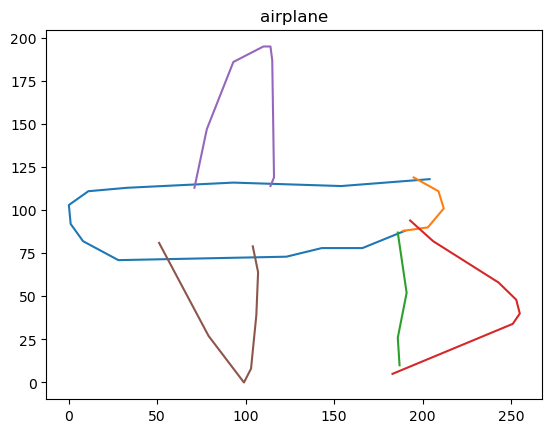

In [49]:
first_key, first_value = next(iter(training_data.items()))
first_drawing = first_value[0]

import matplotlib.pyplot as plt

def draw_sketch(name, drawing_data):
    for stroke in drawing_data:
        x, y = stroke
        plt.plot(x, y)
        plt.title(name)
    plt.show()
draw_sketch(first_drawing["word"], first_drawing["drawing"])

## Processing

In [50]:
max_points = 64 # 2 * 64 values per stroke
max_strokes = 32
only_recognized_doodles = True # only google recognized doodles

In [51]:
from data import clean_data, preprocess_data

In [52]:
def process(data):
    if only_recognized_doodles:
        data = clean_data(data)
    data = preprocess_data(data, max_strokes, max_points)
    return data

working_training_data = process(training_data)
working_validation_data = process(validation_data)

## Model

In [53]:
from data import DrawingFewShotDataset
from torch.utils.data import DataLoader

n_way = 8
k_shot = 8
q_queries = 8

print(k_shot + q_queries, items_per_class)
if num_classes and (n_way > num_classes):
    print("not enough classes loaded 1")
if k_shot + q_queries > items_per_class:
    print("not enough items loaded 1")
training_dataset = DrawingFewShotDataset(working_training_data, n_way, k_shot, q_queries)
training_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True)

if v_num_classes and n_way > v_num_classes:
    print("not enough classes loaded 2")
if k_shot + q_queries > v_items_per_class:
    print("not enough items loaded 2")
validation_dataset = DrawingFewShotDataset(working_validation_data, n_way, k_shot, q_queries, word2idx=training_dataset.word2idx)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

# s_emb, s_lab, q_emb, q_lab = next(iter(dataloader))
# print([dataset.idx2word[label.item()] for label in q_lab.squeeze(0)])
# print(q_emb)

16 256


In [54]:
print(training_dataset.word2idx)
print(validation_dataset.word2idx)

{'airplane': 0, 'animal migration': 1, 'ant': 2, 'The Eiffel Tower': 3, 'aircraft carrier': 4, 'alarm clock': 5, 'ambulance': 6, 'angel': 7, 'The Great Wall of China': 8, 'The Mona Lisa': 9}
{'airplane': 0, 'animal migration': 1, 'ant': 2, 'The Eiffel Tower': 3, 'aircraft carrier': 4, 'alarm clock': 5, 'ambulance': 6, 'angel': 7, 'The Great Wall of China': 8, 'The Mona Lisa': 9}


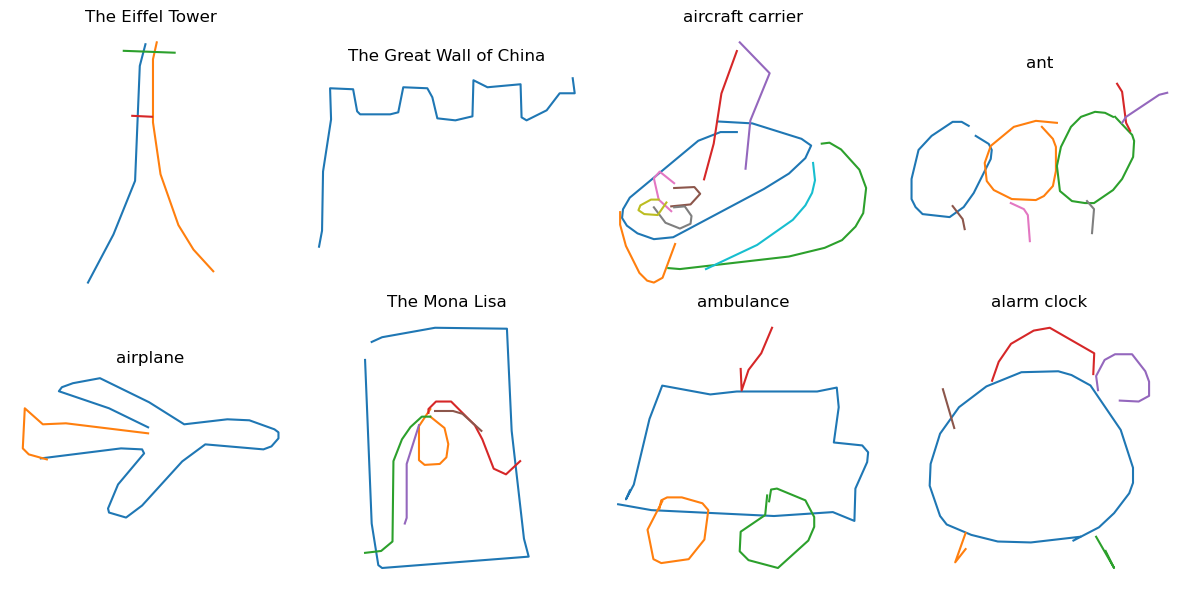

In [55]:
import matplotlib.pyplot as plt

def draw_sketch(dataset, loader, n=1):
    s_emb, s_lab, q_emb, q_lab = next(iter(loader))
    s_emb = s_emb.cpu()
    s_lab = s_lab.cpu()
    q_emb = q_emb.cpu()
    q_lab = q_lab.cpu()

    emb = torch.cat([s_emb, q_emb], dim=1) # shape (1, total_samples, max_strokes, max_points*2)
    lab = torch.cat([s_lab, q_lab], dim=1) # shape (1, total_samples)

    columns = min(max(n % 4, 4), n) # max 4 or fewer if n < 4
    rows = (n + columns - 1) // columns

    fig, axs = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3))
    axs = axs.flatten()

    lab_flat = lab.squeeze(0) # shape (total_samples,)
    for i in range(n):
        ix = i * (k_shot) 
        sketch = emb[0, ix] # shape: (max_strokes, max_points*2)
        label = lab_flat[ix].item()

        for stroke in sketch:
            x = stroke[::2]
            y = stroke[1::2]
            valid = (x != 0) | (y != 0)
            axs[i].plot(x[valid], -y[valid])

        axs[i].set_title(f"{dataset.idx2word[label]}")
        axs[i].set_aspect('equal')
        axs[i].axis('off')

    # hide unused subplots
    for j in range(n, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

draw_sketch(training_dataset, training_dataloader, n=8)

In [56]:
s_emb, s_lab, q_emb, q_lab = next(iter(training_dataloader))
print(s_emb.shape, s_lab.shape) # (1 episode, 64 samples, 32 num strokes, 128 / 2 points) (1 episode, 64 labels?)

torch.Size([1, 64, 32, 128]) torch.Size([1, 64])


In [57]:
from model import Model

model = Model(input_dim=max_points*2, max_strokes=max_strokes).to(device)

# model.forward(s_emb.to(device), s_lab.to(device), q_emb.to(device), n_way)

In [58]:
from solver import Solver

solver = Solver(model, n_way=n_way, device=device)
solver.train(training_dataloader, n_epochs=5)

epoch 1/5, loss: 0.7314
epoch 2/5, loss: 0.2831
epoch 3/5, loss: 0.1579
epoch 4/5, loss: 0.0955
epoch 5/5, loss: 0.0670


In [40]:
solver.train(training_dataloader, n_epochs=5)

epoch 1/5, loss: 0.0492
epoch 2/5, loss: 0.0362
epoch 3/5, loss: 0.0369
epoch 4/5, loss: 0.0254
epoch 5/5, loss: 0.0275


In [59]:
solver.eval(validation_dataloader)

avg test accuracy: 74.66%


In [129]:
import random

def get_class_samples(raw_data, key, idx, k_shot):
    samples_for_class = raw_data[key]
    selected_drawings = random.sample(samples_for_class, min(k_shot, len(samples_for_class)))

    # convert to tensors
    tensor_drawings = [torch.tensor(d, dtype=torch.float32).unsqueeze(0) for d in selected_drawings]
    return (tensor_drawings, torch.tensor([idx] * len(selected_drawings), device=device))

def add_to_support(support_x, supprot_y, drawings, labels):
    new_support_x = torch.cat(drawings, dim=0).to(device) # shape [k, 32, 128]
    new_support_y = labels # shape [k]

    # concatenate existing support_x and support_y
    return (
        torch.cat([support_x, new_support_x], dim=0), # shape [N + k, 32, 128]
        torch.cat([support_y, new_support_y], dim=0)
    )

# testing

key = random.choice(list(working_validation_data.keys()))
idx = validation_dataset.word2idx[key]
print("currently checking '%s' (idx %d)" % (key, idx))
drawing_tensor = torch.tensor(working_validation_data[key][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

n = 10 # ideally number of classes
k = 10 # a respectable amount but still few-shot

# we're testing a specific class, so make sure we get that
samples_x, samples_y = get_class_samples(working_validation_data, key, idx, k)

# create a support set
support_x = torch.empty((0, 32, 128), device=device)
support_y = torch.empty((0,), dtype=torch.long, device=device)
support_x, support_y = add_to_support(support_x, support_y, samples_x, samples_y)

# fill support set with n - 1 classes
filled = {key: True}
while support_x.shape[0] != n * k:
    new_key = random.choice(list(working_validation_data.keys()))
    if filled.get(new_key):
        continue
    filled[new_key] = True

    new_idx = validation_dataset.word2idx[new_key]
    new_samples_x, new_samples_y = get_class_samples(working_validation_data, new_key, new_idx, k)
    support_x, support_y = add_to_support(support_x, support_y, new_samples_x, new_samples_y)

# predict
query_x = drawing_tensor.to(device)

support_x = support_x.unsqueeze(0)
support_y = support_y.unsqueeze(0)

probs = solver.predict(support_x, support_y, query_x)  # [1, num_classes]

topk_probs, topk_indices = probs.topk(8, dim=-1)  # get top n

for i in range(topk_indices.shape[-1]):
    class_idx = int(topk_indices[0, i])
    class_name = validation_dataset.idx2word[class_idx]
    prob = float(topk_probs[0, i])
    print(f"{i+1}. {class_name}: {prob:.4f}")

currently checking 'alarm clock' (idx 5)
1. alarm clock: 0.9970
2. ambulance: 0.0030
3. animal migration: 0.0000
4. ant: 0.0000
5. aircraft carrier: 0.0000
6. airplane: 0.0000
7. The Eiffel Tower: 0.0000
8. angel: 0.0000
